## Imports 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image

from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Importing Data

In [2]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))]) 
    tr_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return tr_df

In [3]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])
    ts_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return ts_df

In [4]:
tr_df = train_df(r"Data\Training")
ts_df = test_df(r"Data\Testing")

In [5]:
tr_df

,Class Path,Class
0,Data\Training\glioma\Tr-glTr_0000.jpg,glioma
1,Data\Training\glioma\Tr-glTr_0001.jpg,glioma
2,Data\Training\glioma\Tr-glTr_0002.jpg,glioma
3,Data\Training\glioma\Tr-glTr_0003.jpg,glioma
4,Data\Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Data\Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,Data\Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,Data\Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,Data\Training\pituitary\Tr-pi_1455.jpg,pituitary


In [6]:
ts_df

,Class Path,Class
0,Data\Testing\glioma\Te-glTr_0000.jpg,glioma
1,Data\Testing\glioma\Te-glTr_0001.jpg,glioma
2,Data\Testing\glioma\Te-glTr_0002.jpg,glioma
3,Data\Testing\glioma\Te-glTr_0003.jpg,glioma
4,Data\Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,Data\Testing\pituitary\Te-pi_0295.jpg,pituitary
1307,Data\Testing\pituitary\Te-pi_0296.jpg,pituitary
1308,Data\Testing\pituitary\Te-pi_0297.jpg,pituitary
1309,Data\Testing\pituitary\Te-pi_0298.jpg,pituitary


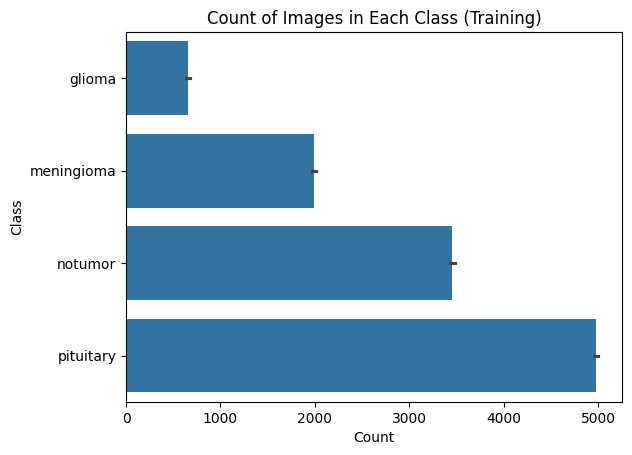

In [7]:
# Count of images in training dataset
plt.figure()
sns.barplot(tr_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Training)")
plt.show()

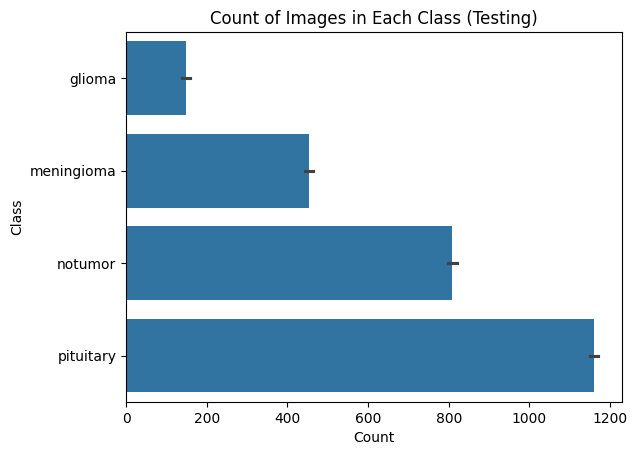

In [8]:
# Count of images in the training daaset
plt.figure()
sns.barplot(ts_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Testing)")
plt.show()

#### Data Preprocessing

In [9]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col="Class Path", 
                                  y_col="Class",
                                  batch_size=batch_size, 
                                  target_size=img_size,)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    batch_size=16, 
                                    target_size=img_size, 
                                    shuffle=True)

# set shuffle equal to True simply for the picture

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [10]:
# Use annomoly detection, the notumor images to the tumor images. Could tell us where the tumor is.

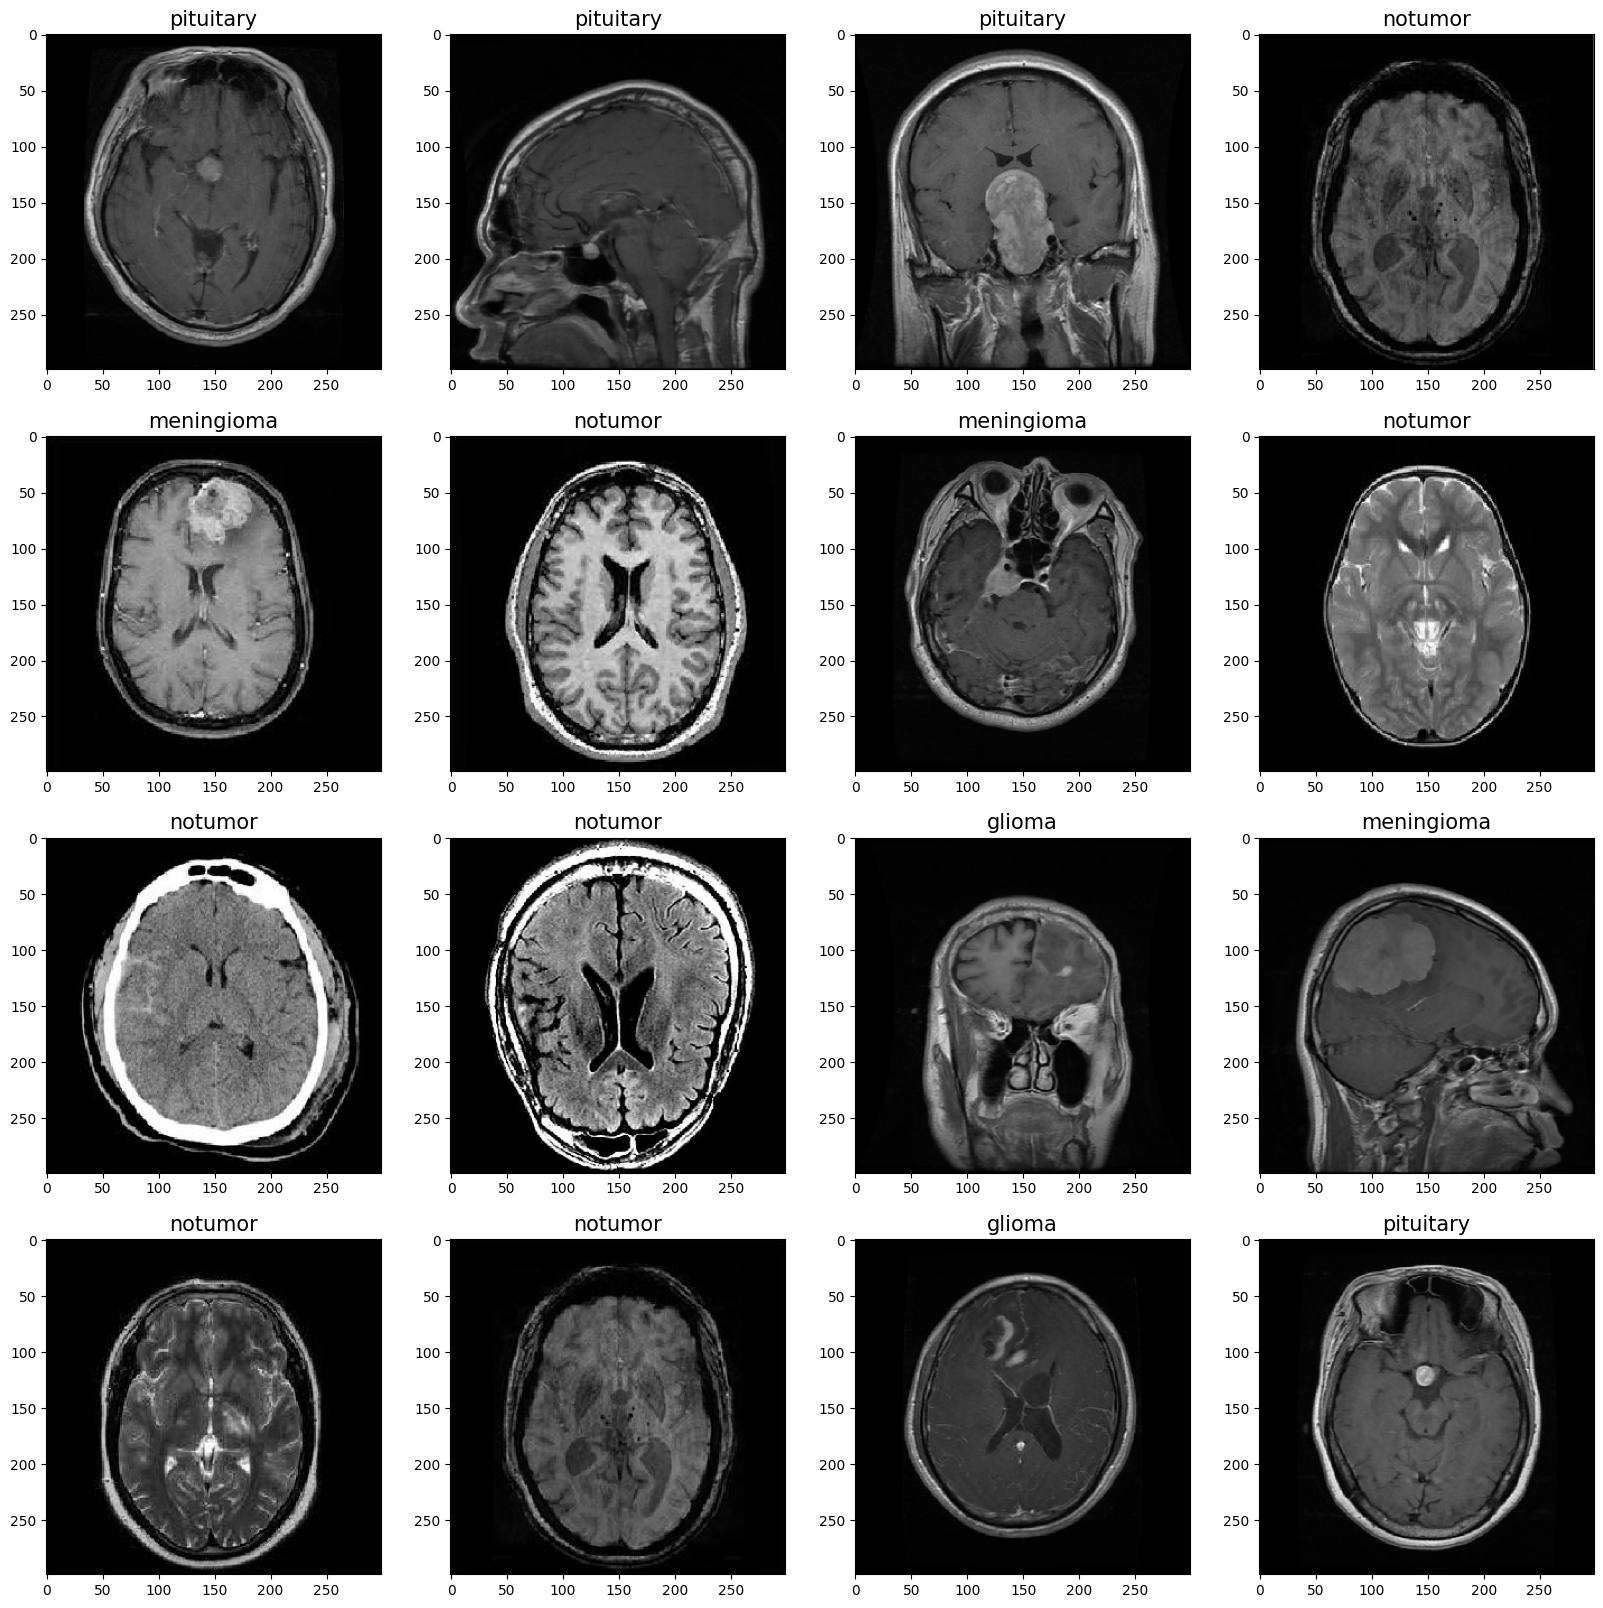

In [11]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i+1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color="k", fontsize=15)
plt.show()

In [12]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col="Class Path", 
                                  y_col="Class",
                                  batch_size=batch_size, 
                                  target_size=img_size,)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    batch_size=16, 
                                    target_size=img_size, 
                                    shuffle=False)

# set shuffle back to false for model and confusion matrix 
# if set to true, then messes up confusion matrix as true labels 
# are also shuffled with the images. 

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [14]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

#### Initial CNN

In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(tr_gen, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(ts_gen, verbose=2)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 141s 786ms/step - accuracy: 0.7904 - loss: 0.9008
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.9599 - loss: 0.1271
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 218ms/step - accuracy: 0.9909 - loss: 0.0366
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 39s 217ms/step - accuracy: 0.9984 - loss: 0.0150
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - accuracy: 0.9996 - loss: 0.0044
82/82 - 36s - 439ms/step - accuracy: 0.9466 - loss: 0.2073
Loss: 0.20734921097755432
Accuracy: 0.9466056227684021


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step


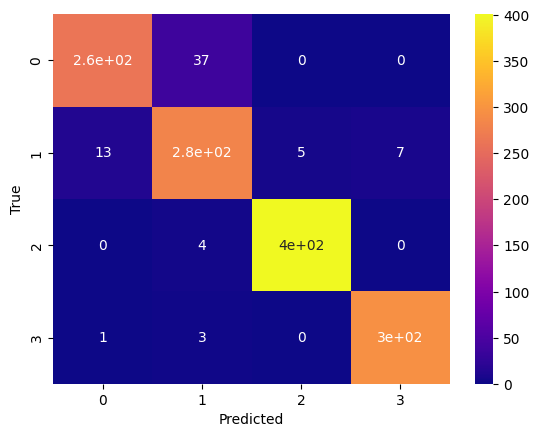

              precision    recall  f1-score   support

      glioma       0.95      0.88      0.91       300
  meningioma       0.86      0.92      0.89       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.98      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



In [16]:
y_pred = np.argmax(model.predict(ts_gen), axis=-1)
y_true = ts_gen.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="plasma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

#### Hyperparameter Tuning

In [19]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(tr_gen, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(ts_gen, verbose=2)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 106s 581ms/step - accuracy: 0.7439 - loss: 1.9762
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 136s 761ms/step - accuracy: 0.9468 - loss: 0.1672
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 172s 954ms/step - accuracy: 0.9881 - loss: 0.0465
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 130s 724ms/step - accuracy: 0.9979 - loss: 0.0169
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.9993 - loss: 0.0081
82/82 - 17s - 207ms/step - accuracy: 0.9550 - loss: 0.1553
Loss: 0.15531955659389496
Accuracy: 0.9549961686134338


82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step


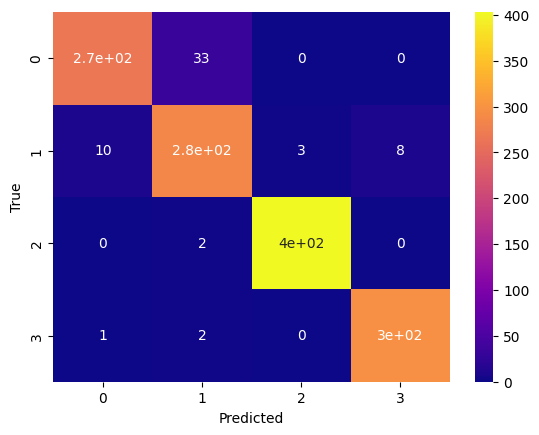

              precision    recall  f1-score   support

      glioma       0.96      0.89      0.92       300
  meningioma       0.89      0.93      0.91       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



In [20]:
y_pred = np.argmax(model.predict(ts_gen), axis=-1)
y_true = ts_gen.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="plasma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

#### Anonaly Detection, autoencoders. 